In [15]:
from dotenv import load_dotenv

from ipynb.income_tax_graph import graph_builder, vector_store, retriever
from ipynb.real_estate_tax_graph import query

load_dotenv()

True

In [16]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')


In [17]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str # 사용자 질문
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'
'income_tax' contains information about income tax up to December 2024
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'.

"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm
    route = router_chain.invoke({'query': query})
    print(f'router route == {route}')
    print(f'route.target == {route.target}')
    return route.target


In [19]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState):
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

In [20]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

In [21]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)
graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [22]:
graph = graph_builder.compile()

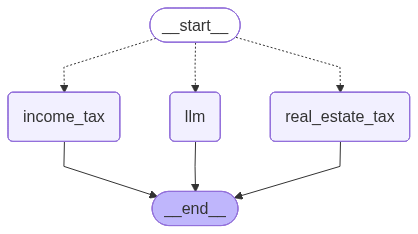

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

router route == target='income_tax'
route.target == income_tax
context: [Document(id='1a3f3af4-0029-4ff5-84fb-6cab853a3730', metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액

{'query': '소득세란 무엇인가요?',
 'context': [Document(id='1a3f3af4-0029-4ff5-84fb-6cab853a3730', metadata={'source': './documents/income_tax.txt'}, page_content='①조 세특례제한법, 또는 이 법 제12조에 따른 과세제외 소득  \n대통령령으로 정하는 임금소득(이하 “임금소득”이라 한다)과 근로소득  \n\n제12조제2항의 세호에 따라 원천징수하는 이자소득 및 배당소득과 제16조제1항제10호에 따른 직장공제회초 관련소득  \n\n\n법인으로 보는 단체 외의 단체 중 소득을 구성함에 배분하지 아니하는 단체로서 단체를 표기하는 금융거래를 하는 단체가 “금융신용기관” 및 비임금소득에 관한 법령이 제20조제1항 목의 이후에 해당하는 금융사업을 하는 단체(이하 “금융회사”等이란)로부터 받은 이자소득 및 배당소득  \n\n\n①조 세특례제한법에 따른 보통계소득  \n\n\n제30조부터 제35조까지의 규정 외의 이자소득과 배당소득(제17조제1항제8호에 따른 배당소득을 제외한다)으로서 그 소득의 합계액이 2천만원(이하 “이자소득의 종합세액기준금액”이라 한다) 이하인 경우 제17조에 따른 원천징수된 소득  \n\n\n해당 과세기간에 배당행정을 정하는 총수입금액의 합계액이 2천만원 이하인 자의 주택임대소득(이하 “분리과세 주택임대소득”이라 한다). 이 경우 주택임대소득이 산정 등에 필요한 대책행령으로 정한다.  \n\n\n다음 각 목 외의 기타소득(이하 “분리과세 기타소득”이라 한다)  \n\n\n가. 제21조제1항제3호 제4항, 제19조, 제20조제1항, 제22조제2항, 제26조 및 제26조의2 및 제 127조에 따라 원천징수(제21조제19항에 의하여 원천징수되지 아니하는 경우를 포함한다) 소득. 다만, 해당 소득이 있는 거주자가 종합소득과세표준을 계산해 고소득을 합산하는 경우 그 소득은 분리과세로 세액계산에 제외한다.  \n나. 제21조제19항제2조 및 같은 조 

In [25]:
initial_state = {'query': '떡볶이가 맛있는데는 어딘가요'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '떡볶이가 맛있는데는 어딘가요',
 'answer': "떡볶이가 맛있어 유명한 곳은 여러 군데가 있습니다. 서울의 경우, 특히 신당동 떡볶이 골목이 유명하며, 이곳에는 다양한 떡볶이 가게가 밀집해 있습니다. 또한, 강남의 '떡볶이 집'이나, 홍대 근처의 '홍대 떡볶이'도 많은 사람들에게 사랑받는 곳입니다.\n\n각 지역마다 맛있는 떡볶이 가게가 많으니, 근처에 있는 가게를 탐방해보는 것도 좋은 방법입니다. 혹시 특정 지역을 말씀해 주시면 더 구체적인 정보를 제공해드릴 수 있습니다!"}